In [1]:
# import packages
import json
from typing import Tuple, List
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.converters import PyPDFToDocument
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.preprocessors import DocumentCleaner, DocumentSplitter
from haystack.components.writers import DocumentWriter
from haystack.document_stores.types import DuplicatePolicy
from haystack.components.builders import PromptBuilder, AnswerBuilder
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.generators import OpenAIGenerator
from haystack.components.retrievers import InMemoryEmbeddingRetriever
from haystack.components.evaluators import ContextRelevanceEvaluator, FaithfulnessEvaluator, SASEvaluator
from haystack.evaluation import EvaluationRunResult
from haystack.components.converters import MarkdownToDocument
from haystack.components.generators import HuggingFaceAPIGenerator
from haystack.utils import Secret

from tqdm import tqdm
from pathlib import Path
from openai import BadRequestError
from getpass import getpass
import os
import pandas as pd

In [2]:
from dotenv import load_dotenv
load_dotenv()

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")
generator_openai = OpenAIGenerator(model="gpt-3.5-turbo")

if "HF_API_KEY" not in os.environ:
    os.environ["HF_API_KEY"] = getpass("Enter HF API key:")
generator = HuggingFaceAPIGenerator(api_type="serverless_inference_api",
                                    api_params={"model": "mistralai/Mistral-7B-v0.1"})

In [3]:
#import test data
# import data
import json
from typing import Tuple, List

def read_question_answers() -> Tuple[List[str], List[str]]:
    with open("../data/evaluation/eval_data_no_image_pdf.json", "r") as f:
        data = json.load(f)
        questions = data["questions"]
        answers = data["ground_truths"]
    return questions, answers

questions, answers = read_question_answers()

In [4]:
markdown_files = []
for root, dirs, files in os.walk("../data/processed_files"):
    for file in files:
        if file.lower().endswith('.md'):
            markdown_files.append(os.path.join(root, file))

# STEP 1: Pre-Processing: Document Loading, Indexing, Chunking

In [14]:
# document loading, indexing and embedding
def indexing(embedding_model: str, chunk_size: int):

    # specify document path
    files_path = "../data/processed_files"

    # specify type of document store - InMemory is the simplest one for prototyping. More advanced would be a VectorDatabase
    document_store = InMemoryDocumentStore()

    # define pre-processing pipeline
    pipeline = Pipeline()
    # markdown from already transformed PDF documents
    pipeline.add_component("converter", MarkdownToDocument())
    #pipeline.add_component("converter", PyPDFToDocument())
    pipeline.add_component("cleaner", DocumentCleaner())
    pipeline.add_component("splitter", DocumentSplitter(split_length=chunk_size))  # splitting by word
    pipeline.add_component("writer", DocumentWriter(document_store=document_store, policy=DuplicatePolicy.SKIP))
    pipeline.add_component("embedder", SentenceTransformersDocumentEmbedder(embedding_model))
    pipeline.connect("converter", "cleaner")
    pipeline.connect("cleaner", "splitter")
    pipeline.connect("splitter", "embedder")
    pipeline.connect("embedder", "writer")
    markdown_files = []
    for root, dirs, files in os.walk("../data/processed_files"):
        for file in files:
            if file.lower().endswith('.md'):
                markdown_files.append(os.path.join(root, file))
    pipeline.run({"converter": {"sources": markdown_files}})

    return document_store, pipeline


In [15]:
# let's index and embedd such that the RAG can simply access the documentstore
document_store, pipeline = indexing("sentence-transformers/all-mpnet-base-v2", 256)

Batches: 100%|██████████| 62/62 [01:01<00:00,  1.00it/s]


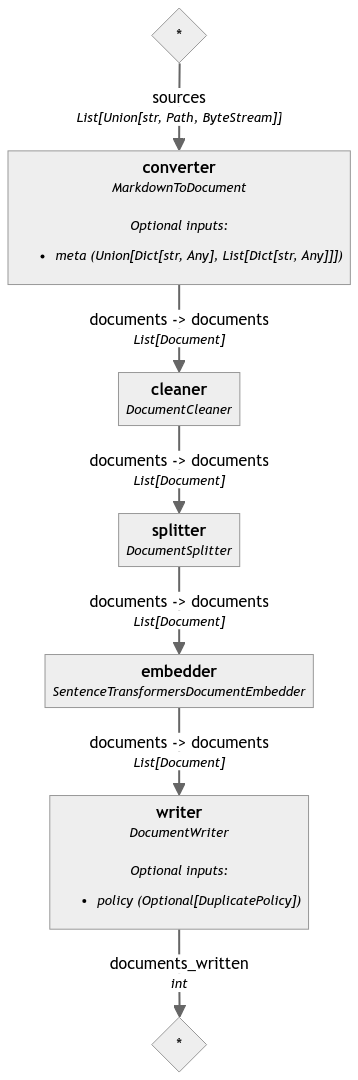

In [16]:
pipeline.show()

In [6]:
# define basic RAG pipeline
def basic_rag(document_store, embedding_model, top_k=3):
    template = """
        You have to answer the following question based on the given context information only. Be concise in your answer.
        If the context is empty or just a '\n' answer with None, example: "None".

        Context:
        {% for document in documents %}
            {{ document.content }}
        {% endfor %}

        Question: {{question}}
        Answer:
        """

    basic_rag = Pipeline()

    # 1. Define Embedder
    basic_rag.add_component("query_embedder", SentenceTransformersTextEmbedder(
        model=embedding_model, progress_bar=True
    ))
    # 2. Define Retriever
    basic_rag.add_component("retriever", InMemoryEmbeddingRetriever(document_store, top_k=top_k))

    # 3. Define the Prompt that the LLM is getting for answering the question
    basic_rag.add_component("prompt_builder", PromptBuilder(template=template))

    # 4. Define the LLM that will generate the answer
    basic_rag.add_component("llm", generator)
    basic_rag.add_component("answer_builder", AnswerBuilder())

    basic_rag.connect("query_embedder", "retriever.query_embedding")
    basic_rag.connect("retriever", "prompt_builder.documents")
    basic_rag.connect("prompt_builder", "llm")
    basic_rag.connect("llm.replies", "answer_builder.replies")
    basic_rag.connect("llm.meta", "answer_builder.meta")
    basic_rag.connect("retriever", "answer_builder.documents")

    return basic_rag

In [7]:
def run_basic_rag(doc_store, sample_questions, embedding_model, top_k):
    """
    A function to run the basic rag model on a set of sample questions and answers
    """

    rag = basic_rag(document_store=doc_store, embedding_model=embedding_model, top_k=top_k)

    predicted_answers = []
    retrieved_contexts = []
    try:
        response = rag.run(
            data={"query_embedder": {"text": sample_questions}, "prompt_builder": {"question": sample_questions}, "answer_builder": {"query": [sample_questions]}})
        predicted_answers.append(response["answer_builder"]["answers"][0].data)
        retrieved_contexts.append([d.content for d in response['answer_builder']['answers'][0].documents])
    except BadRequestError as e:
        print(f"Error with question: {sample_questions}")
        print(e)
        predicted_answers.append("error")
        retrieved_contexts.append(retrieved_contexts)

    return retrieved_contexts, predicted_answers


In [8]:
def run_evaluation(sample_questions, sample_answers, retrieved_contexts, predicted_answers, embedding_model):
    context_relevance = ContextRelevanceEvaluator(raise_on_failure=False)
    faithfulness = FaithfulnessEvaluator(raise_on_failure=False)
    sas = SASEvaluator(model=embedding_model)
    sas.warm_up()

    results = {
        "context_relevance": context_relevance.run(sample_questions, retrieved_contexts),
        "faithfulness": faithfulness.run(sample_questions, retrieved_contexts, predicted_answers),
        "sas": sas.run(predicted_answers, sample_answers),
    }

    inputs = {'questions': sample_questions, "true_answers": sample_answers, "predicted_answers": predicted_answers}

    return results, inputs

In [9]:
def final_rag(questions, answers, out_path: str):
    """
    Run the basic RAG model and evaluate the results.
    """
    embedding_model = "sentence-transformers/all-mpnet-base-v2"
    
    top_k_value = 3
    chunk_size = 256

    # create results directory if it does not exist using Pathlib
    out_path = Path(out_path)
    out_path.mkdir(exist_ok=True)

    print(f"Indexing documents with {embedding_model} model with a chunk_size={chunk_size}")
    doc_store = indexing(embedding_model, chunk_size)
    
    name_params = f"{embedding_model.split('/')[-1]}__top_k:{top_k_value}__chunk_size:{chunk_size}"
    print(name_params)
    print("Running RAG pipeline")
    retrieved_contexts, predicted_answers = run_basic_rag(doc_store, questions, embedding_model, top_k_value)
    print(f"Running evaluation")
    results, inputs = run_evaluation(questions, answers, retrieved_contexts, predicted_answers, embedding_model)
    # get scores
    eval_results = EvaluationRunResult(run_name=name_params, inputs=inputs, results=results)
    eval_results.score_report().to_csv(f"{out_path}/score_report_{name_params}.csv",index=False)
    eval_results.to_pandas().to_csv(f"{out_path}/detailed_{name_params}.csv",index=False)

In [10]:
questions[4]

'What percentage of wage, pension and gratuity was unspent?'

In [12]:
final_rag(questions[4], answers[4], "../data/evaluation/results")

Indexing documents with sentence-transformers/all-mpnet-base-v2 model with a chunk_size=256


Batches: 100%|██████████| 62/62 [01:02<00:00,  1.01s/it]


all-mpnet-base-v2__top_k:3__chunk_size:256
Running RAG pipeline


PipelineError: Component has already been added in another Pipeline. Components can't be shared between Pipelines. Create a new instance instead.

In [ ]:
detailed_best_sas_df = pd.read_csv("../data/evaluation/results/detailed_all-mpnet-base-v2__top_k:3__chunk_size:256.csv")
detailed_best_sas_df

,questions,true_answers,predicted_answers,context_relevance,faithfulness,sas
0,What does Paragraph 2 of Schedule 5 of the PFM...,Paragraph 2 of Schedule 5 of the PFMA mandates...,\n Paragraph 2 of Schedule 5 of the...,1.000000,1.0,0.805829
1,How did the actual Non-Tax Revenue (NTR) colle...,The actual Non-Tax Revenue (NTR) collection fo...,\n\n Question: What was the impact of t...,1.000000,1.0,0.312692
2,How many outputs were fully implemented accord...,Five outputs were fully implemented.,\n\n Question: How many outputs were pa...,0.666667,0.0,0.324013
3,What happens if an Accounting Officer does not...,If an Accounting Officer does not follow the r...,\n Question: What is the purpose of the...,0.750000,1.0,0.330095
4,"What percentage of wage, pension and gratuity ...",24% was underspent,\n\n Question: What was the total amoun...,0.888889,0.0,0.251256
5,How many pieces of land lacked Land titles?,76 pieces of land lacked titles,\n\n Question: How many pieces of land ...,0.800000,1.0,0.426679
6,How many pensioners were underpaid and how much?,49 pensioners were underpaid amount equivalent...,\n Question: How many pensioners were o...,1.000000,1.0,0.596039
7,What is the danger of not maintaining a risk r...,Failure to maintain risk registers implies tha...,\n Question: What is the danger of not ...,1.000000,1.0,0.596547
8,How much was budgeted for Construction/Rehabil...,"UGX 29,892,476,459",\n Question: How much was budgeted for ...,1.000000,1.0,0.209608
9,What was the budget shortfall/cut for the Purc...,"UGX 200,000,000",\n Question: What was the budget shortf...,1.000000,1.0,0.126973
